<a href="https://colab.research.google.com/github/sergioar3143/AprendizajeProfundo/blob/main/Tarea2_Redes_convolucionales_y_transferencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar bibliotecas y descargar el dataset de FairFace

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import correlate2d, convolve2d
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import PIL
import copy
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
from sklearn.model_selection import train_test_split
import torchvision as tv

# Por reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

!gdown --id 1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
!gdown --id 1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
!gdown --id 1wOdja-ezstMEp81tX1a-EYkFebev4h7D
!rm -r "/content/FairFace"
!unzip "/content/fairface-img-margin025-trainval.zip" -d "/content/FairFace"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/FairFace/val/5370.jpg  
  inflating: /content/FairFace/val/5596.jpg  
  inflating: /content/FairFace/val/5875.jpg  
  inflating: /content/FairFace/val/5878.jpg  
  inflating: /content/FairFace/val/5879.jpg  
  inflating: /content/FairFace/val/5883.jpg  
  inflating: /content/FairFace/val/6126.jpg  
  inflating: /content/FairFace/val/6132.jpg  
  inflating: /content/FairFace/val/6144.jpg  
  inflating: /content/FairFace/val/6150.jpg  
  inflating: /content/FairFace/val/6340.jpg  
  inflating: /content/FairFace/val/7190.jpg  
  inflating: /content/FairFace/val/7734.jpg  
  inflating: /content/FairFace/val/7747.jpg  
  inflating: /content/FairFace/val/7872.jpg  
  inflating: /content/FairFace/val/7940.jpg  
  inflating: /content/FairFace/val/8065.jpg  
  inflating: /content/FairFace/val/8069.jpg  
  inflating: /content/FairFace/val/8125.jpg  
  inflating: /content/FairFace/val/8202.jpg  
  inflating: /conte

#Operación de convolución

Se carga el conjunto de datos y se normaliza para que los pixeles se encuentren en el rango de (0-1).


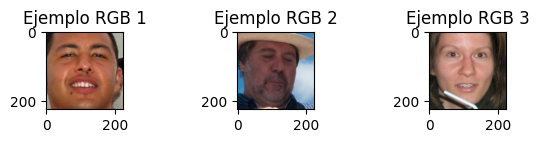

In [2]:
imagen0 = cv2.imread("/content/FairFace/val/10897.jpg")
imagen0 = cv2.cvtColor(imagen0,cv2.COLOR_BGR2RGB)
imagen0 = imagen0 / imagen0.max()

imagen1 = cv2.imread("/content/FairFace/val/8074.jpg")
imagen1 = cv2.cvtColor(imagen1,cv2.COLOR_BGR2RGB)
imagen1 = imagen1 / imagen1.max()

imagen2 = cv2.imread("/content/FairFace/val/9821.jpg")
imagen2 = cv2.cvtColor(imagen2,cv2.COLOR_BGR2RGB)
imagen2 = imagen2 / imagen2.max()

fig, axs = plt.subplots(1, 3, figsize=(7, 1))
axs[0].imshow(imagen0, cmap = 'gray')
axs[0].set_title('Ejemplo RGB 1')
axs[1].imshow(imagen1, cmap = 'gray')
axs[1].set_title('Ejemplo RGB 2')
axs[2].imshow(imagen2, cmap = 'gray')
axs[2].set_title('Ejemplo RGB 3')
plt.show()

Correlación cruzada y convolución

Ahora consideremos las operación de convolución entre una imagen $I$ y un filtro $W$, la cual está definida por

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n}
$$

En lugar de la convolución, frecuentemente se ocupa la operación de correlación cruzada para llevar a cabo las capas convolucionales. Esta operación es similar a la convolución pero sin voltear el filtro (por lo que pierde la propiedad de conmutatividad) y está dada por

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i + m, j + n} W_{m,n}
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$.

In [3]:
def conv2d(I, W, b, stride = 1):
  h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
  k=I.shape[2]
  a = np.zeros((h_s, w_s, k))
  for channel in range(k):
    for i in range(h_s):
      for j in range(w_s):
        I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1], channel]
        a[i, j,channel] = (I_m * W[:,:,channel]).sum() + b
  return a

Filtro

Definamos un tensor que represente 3 filtros de $3 \times 3$ que detecte bordes en cierta orientación:

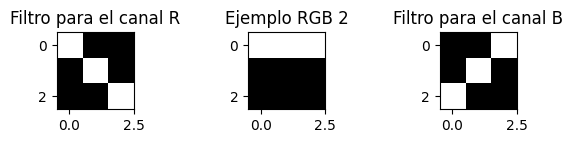

In [4]:
import math
filter1 = np.zeros((3,3,3))
np.fill_diagonal(filter1[:,:,0], np.array([1, 1, 1]))
filter1[:,:,1]=np.asarray([(1,1,1),(0,0,0),(0,0,0)])
filter1[:,:,2]=filter1[:,:,0][::-1]
filter1=filter1/math.sqrt(3) ##Normalizar filtros para que el resultado se encuentre entre 0 y 1

fig, axs = plt.subplots(1, 3, figsize=(7, 1))
axs[0].imshow(filter1[:,:,0] * 0.5 + 0.5, cmap = 'gray')
axs[0].set_title('Filtro para el canal R')
axs[1].imshow(filter1[:,:,1] * 0.5 + 0.5, cmap = 'gray')
axs[1].set_title('Ejemplo RGB 2')
axs[2].imshow(filter1[:,:,2] * 0.5 + 0.5, cmap = 'gray')
axs[2].set_title('Filtro para el canal B')
plt.show()

También se define la función

In [5]:
sigmoid = lambda z: 1. / (1. + np.exp(-z))

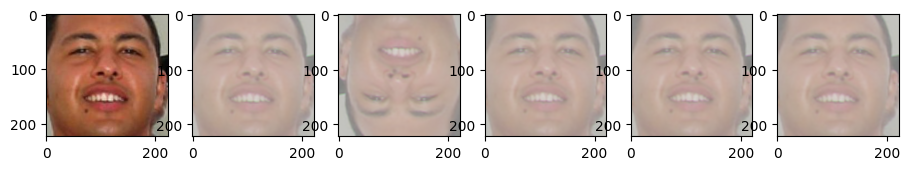

In [6]:
ccorr=np.zeros((222, 222, 3))
for ch in range(ccorr.shape[2]):
  ccorr[:,:,ch] =sigmoid(correlate2d(imagen0[:,:,ch], filter1[:,:,ch], mode = 'valid'))

ccorr2=np.zeros((222, 222, 3))
for ch in range(ccorr2.shape[2]):
  ccorr2[:,:,ch] = sigmoid(correlate2d(filter1[:,:,ch], imagen0[:,:,ch], mode = 'valid'))

conv=np.zeros((222, 222, 3))
for ch in range(conv.shape[2]):
  conv[:,:,ch] = sigmoid(convolve2d(imagen0[:,:,ch], filter1[:,:,ch], mode = 'valid'))

conv2=np.zeros((222, 222, 3))
for ch in range(conv.shape[2]):
  conv2[:,:,ch] = sigmoid(convolve2d(filter1[:,:,ch], imagen0[:,:,ch], mode = 'valid'))

a = sigmoid(conv2d(imagen0, filter1, 0))

fig, axs = plt.subplots(1, 6, figsize=(11, 3))
axs[0].imshow(imagen0)
axs[1].imshow(ccorr)
axs[2].imshow(ccorr2)
axs[3].imshow(conv)
axs[4].imshow(conv2)
axs[5].imshow(a)
plt.show()

#Clasificación de rostros por grupo etario

Construimos un `DataFrame` de Pandas del conjunto de entrenamiento y validación usando la función pd.read_csv y se muestra el contenido del archivo.

In [7]:
df_train = pd.read_csv('/content/fairface_label_train.csv')
df_val = pd.read_csv('/content/fairface_label_val.csv')
df_train.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


Generamos un diccionario que mapea la cadena de cada nombre de las clases a un entero y otro diccionario para hacer el mapeo inverso.

In [8]:
clase=list(np.unique(df_train['age']))
clase_a_ind = {c:i for i,c in enumerate(clase)}
ind_a_clase = {i:c for i,c in enumerate(clase)}

for i in clase:
  print(f'A la clase de {i} años le corresponde el indice {clase_a_ind[i]}')

A la clase de 0-2 años le corresponde el indice 0
A la clase de 10-19 años le corresponde el indice 1
A la clase de 20-29 años le corresponde el indice 2
A la clase de 3-9 años le corresponde el indice 3
A la clase de 30-39 años le corresponde el indice 4
A la clase de 40-49 años le corresponde el indice 5
A la clase de 50-59 años le corresponde el indice 6
A la clase de 60-69 años le corresponde el indice 7
A la clase de more than 70 años le corresponde el indice 8


Se crea la variable índice en el `DataFrame`.

In [9]:
df_train['ind']=0
df_val['ind']=0
for i in clase:
  idx=df_train.loc[:,'age']==i
  df_train.loc[idx, 'ind']=clase_a_ind[i]

  idx=df_val.loc[:,'age']==i
  df_val.loc[idx, 'ind']=clase_a_ind[i]

Los datos se dividen en Datos de entrenamiento, Datos de validación y Datos de prueba.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df_train['file'], df_train['ind'], test_size=0.3, random_state=42, shuffle=True, stratify=df_train['ind'])
X_test , y_test = df_val['file'], df_val['ind']

Visualizamos el histograma de imágenes por categoría del conjunto de entrenamiento y validación.

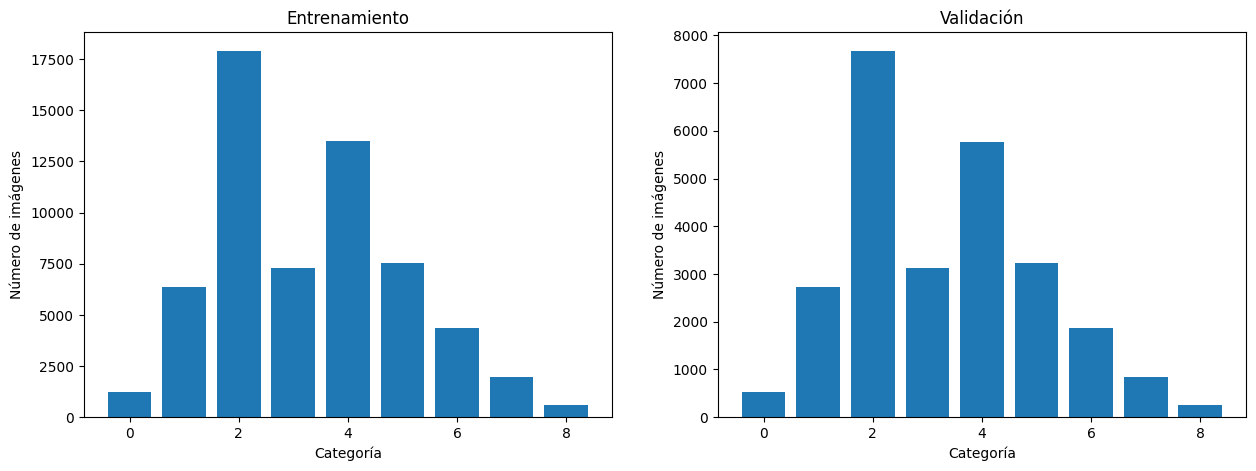

In [11]:
idx_ent, cuentas_ent = np.unique(y_train, return_counts=True)
idx_val, cuentas_val = np.unique(y_val, return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_ent)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')

axs[1].bar(x=idx_val, height=cuentas_val)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

plt.show()

Clase para FairFace

Como podemos observar, el conjunto de datos se encuentra dividido en subconjuntos de entrenamiento, prueba y validación, los cuales están contenidos en los directorios `FairFace/train` y `FairFace/val`. Estos directorios contienen un subdirectorio por cada clase de grupo etario y dentro de cada uno de ellos están las imágenes correspondientes.

![PyTorch DataLoaders](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb0SVvH%2FbtqLq2FmuEs%2F1hnCz8VL9wvXPKTOTXzvOk%2Fimg.jpg)

Fuente: [https://jackyoon5737.tistory.com/203](https://jackyoon5737.tistory.com/203).

Vamos a recopilar la ruta de cada una de estas imágenes con su correspondiente etiqueta. Para ello definiremos la subclase de `Dataset` del submódulo `data` de `utils`. Cualquier clase para un conjunto de datos debe incluir la definición de los siguientes tres métodos:
- `__init__`: Constructor de la clase. Usualmente recibe la ruta o archivo con el subconjunto de datos y las transformaciones a aplicarles y crea una estructura para cargar los datos.
- `__getitem__`: Es un método especial donde se define el comportamiento del operador paréntesis. Típicamente en este método se especifica la lectura y transformación de un ejemplo del subconjunto dado un índice de la estructura.
- `__len__`: Este es un método especial que especifica el comportamiento de la función `len` sobre una instancia.



In [12]:
class Face_age(Dataset):
  def __init__(self, x, y, raiz, transform = None):
    self.x = x
    self.y = y
    self.raiz = raiz
    self.transform = transform
    self.disp = 'cuda' if torch.cuda.is_available() else 'cpu'

  def __getitem__(self, idx):
    img = PIL.Image.open(self.raiz+"/"+self.x.iloc[idx])
    cat = self.y.iloc[idx]
    cat = nn.functional.one_hot(torch.tensor(cat), num_classes=9)
    cat = cat.to(dtype=torch.float32, device=self.disp)

    if self.transform:
      img = self.transform(img)
      img = img.to(self.disp)

    return img, cat

  def __len__(self):
    return len(self.x)


Se crea una instancia para la clase Face_age y se define que los datos serán guardados en el cpu.

In [13]:
dir_raiz = 'FairFace'
ds_ent = Face_age(X_train, y_train, dir_raiz)
ds_ent.disp="cpu"

Con esta instancia podemos crear un iterador para ir cargando las imágenes, también se observa la salida de la clase Face_age.

In [14]:
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

print(f'Imagen = {img_ent}, Categoría = {cat_ent}')

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7DC68F718460>, Categoría = 7


Se muestra la imagen que se obtiene en la salida.

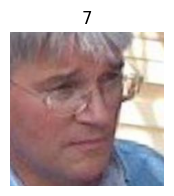

(224, 224)


In [15]:
plt.figure(figsize = (2,2))
plt.imshow(img_ent)
plt.title(cat_ent)
plt.axis('off')
plt.show()
print(img_ent.size)

Transformaciones sobre imágenes

En muchos casos, se aplican transformaciones a los datos leídos. Por ej. se redimensionan las imágenes a un tamaño fijo, se convierten a instancias de `Tensor`, se escalan los valores de los pixeles, etc. Debido a que estas transformaciones son específicas a cada modalidad y tipo de datos, están definidas en bibliotecas que son parte del mismo ecosistema de PyTorch (o externas como [`timm`](https://timm.fast.ai/)) pero separadas de la biblioteca principal. Para imágenes, PyTorch cuenta con la biblioteca [`torchvision`](https://pytorch.org/vision), que incluye clases para extraer y cargar conjuntos de datos, arquitecturas populares de redes neuronales, valores de pesos y sesgos de arquitecturas preentrenadas, transformaciones comunes (algunas de las cuales son subclases de `Module`) y otras clases, funciones y herramientas de visión por computadora.

Debido a que durante el entrenamiento las redes neuronales se alimentan con lotes de imágenes a la vez, es conveniente redimensionarlas para tener un tamaño fijo (por ej. de $H = 64$ y $W = 64$). Podemos redimensionar una imagen de Pillow con la forma $(H, W, C)$ instanciando la clase `Resize` del módulo `transforms` de `torchvision`, donde $H$ es el alto (número de filas), $W$ es el ancho (número de columnas) y $C$ es el la profundidad (número de canales).

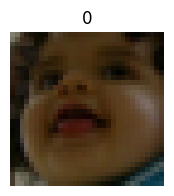

In [16]:
IMG_SIZE = 32

tsfm = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias = True),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dir_raiz = 'FairFace'
ds_ent = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

plt.figure(figsize = (2,2))
plt.imshow(img_ent.permute(1, 2, 0).cpu().numpy())
plt.title(cat_ent)
plt.axis('off')
plt.show()

Se instancia la clase Face_age para los conjuntos de entrenamiento y validación, se agregan transformaciones para el aumento de datos, también se usa la clase `DataLoader` para facilitar la carga de datos por lotes.

In [17]:
dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

 Funciones para el entrenamiento

Para facilitar el entrenamiento, definimos diversas funciones.

 Guardar _checkpoint_

Podemos guardar el estado del entrenamiento y de un modelo mediante la función `save`.

In [18]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)

Registrar información para Tensorboard

Para guardar información que pueda visualizarse con Tensorboard, instanciamos la clase `SummaryWriter` del submódulo `tensorboard` del módulo `utils` y escribimos información mediante los distintos métodos disponibles (por ej. `add_scalar`, `add_image`, `add_histogram`, etc.).

In [19]:
def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

Métrica de exactitud

Definimos una función para calcular la exactitud:

$$
exactitud = \frac{\#correctos}{\#total}
$$

In [20]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y.argmax(dim=-1)
  #cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

Paso de entrenamiento

Definimos una función que realiza un paso de entrenamiento, a la cual llamaremos `paso_ent`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- La métrica a evaluar (`metrica`)
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- Una instancia de `Tensor` con el lote de entradas (`X`).
- Una instancia de `Tensor` con el lote de salidas (`y`).

La función obtiene las predicciones del modelo para las entradas, calcula la pérdida, obtiene los gradientes y actualiza todos los parámetros del modelo mediante el optimizador pasado como argumento.

In [21]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with torch.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso

También definimos el ciclo de entrenamiento principal, que llamaremos `entrena`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- La métrica a evaluar (`metrica`)
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- El cargador de datos del subconjunto de entrenamiento (`entdl`).
- El cargador de datos del subconjunto de validación (`valdl`).
- El dispositivo en el que se ejecutará el modelo (`disp`).
- La ruta al archivo donde se guardará el estado del entrenamiento y el modelo (`ckptpath`).
- El número de épocas de entrenamiento (`n_epocas`).
- La ruta al directorio donde se guardará la información para Tensorboard (`tbdir`).

Para cada una de las épocas, va tomando un lote de entradas y salidas a la vez, con los cuales se realiza un paso de entrenamiento.

In [22]:
def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          metrica.__name__ + '_ent': np.zeros(n_epocas),
          metrica.__name__ + '_val': np.zeros(n_epocas)}

  tbwriter = SummaryWriter(tbdir)
  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote,ylote) in enumerate(entdl):
      #print(Xlote.shape)
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist['perdida_ent'][e] += perdida_paso
      hist[metrica.__name__ + '_ent'][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['perdida_val'][e] += fp(y_hat, ylote)
        hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

    hist['perdida_ent'][e] /=  n_lotes_ent
    hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
    hist['perdida_val'][e] /=  n_lotes_val
    hist[metrica.__name__ + '_val'][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter, e, hist)

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')

  return modelo, mejor_modelo, hist

In [23]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        if in_channels != out_channels2:
          self.conv1x1 = nn.Conv2d(in_channels, out_channels2, 1)
        else:
          self.conv1x1 = None

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W]
            ##Depthwise conv
            nn.Conv2d(in_channels, out_channels2, kernel_size=7, groups=in_channels, padding = 'same'),
            # [N, O1, H, W]
            nn.GroupNorm(1, out_channels2),
            # [N, O1, H, W]
            nn.Conv2d(out_channels2, out_channels1 ,kernel_size=1),
            nn.GELU(),
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(out_channels1,out_channels2, kernel_size=1, padding = 'same'),
            # [N, O2, H, W]
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        if self.conv1x1:
          x = self.conv1x1(x)
        x = x1 + x
        return x

In [25]:
class DeepConv(nn.Module):

    def __init__(self):
        super(DeepConv, self).__init__()
        self.num_feats = 768
        # [N, 3, 32, 32] => [N, 96, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 32, 32] => [N, 96, 32, 32]
            ConvBlock(in_channels=3, out_channels=(384,96)),
            # [N, 96, 32, 32] => [N, 96, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 96, 16, 16] => [N, 192, 16, 16]
            ConvBlock(in_channels=96, out_channels=(768,192)),
            # [N, 192, 16, 16] => [N, 192, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 192, 8, 8] => [N, 384, 8, 8]
            ConvBlock(in_channels=192, out_channels=(1536,384)),
            # [N, 384, 8, 8] => [N, 384, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 384, 4, 4] => [N, 768, 4, 4]
            ConvBlock(in_channels=384, out_channels=(3072,768))
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # [N, 3, 32, 32] => [N, 3x32x32]
        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 9)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        x = self.cnn(x)
        x = self.gap(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = torch.flatten(x,1)
        # [N, 3x32x32] => [N, 1]
        x = self.cls(x)
        return nn.functional.softmax(x,dim=1)

In [47]:
model = DeepConv()
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(y)

it_ent = iter(trn_ds)
img_ent, cat_ent = next(it_ent)
print(cat_ent)

tensor([[0.0873, 0.1084, 0.1109, 0.1184, 0.1070, 0.1126, 0.1372, 0.1067, 0.1115]],
       grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')



Época 0: Perdida(E) = 2.081, exactitud(E) = 0.293, Perdida(V) = 2.075, exactitud(V) = 0.299

Época 1: Perdida(E) = 2.073, exactitud(E) = 0.303, Perdida(V) = 2.071, exactitud(V) = 0.307

Época 2: Perdida(E) = 2.070, exactitud(E) = 0.308, Perdida(V) = 2.069, exactitud(V) = 0.309

Época 3: Perdida(E) = 2.065, exactitud(E) = 0.315, Perdida(V) = 2.068, exactitud(V) = 0.313

Época 4: Perdida(E) = 2.061, exactitud(E) = 0.319, Perdida(V) = 2.056, exactitud(V) = 0.324

Época 5: Perdida(E) = 2.056, exactitud(E) = 0.325, Perdida(V) = 2.057, exactitud(V) = 0.323

Época 6: Perdida(E) = 2.052, exactitud(E) = 0.329, Perdida(V) = 2.062, exactitud(V) = 0.318

Época 7: Perdida(E) = 2.048, exactitud(E) = 0.334, Perdida(V) = 2.052, exactitud(V) = 0.328

Época 8: Perdida(E) = 2.044, exactitud(E) = 0.340, Perdida(V) = 2.045, exactitud(V) = 0.335

Época 9: Perdida(E) = 2.040, exactitud(E) = 0.343, Perdida(V) = 2.049, exactitud(V) = 0.332

Época 10: Perdida(E) = 2.037, exactitud(E) = 0.348, Perdida(V) = 2.04

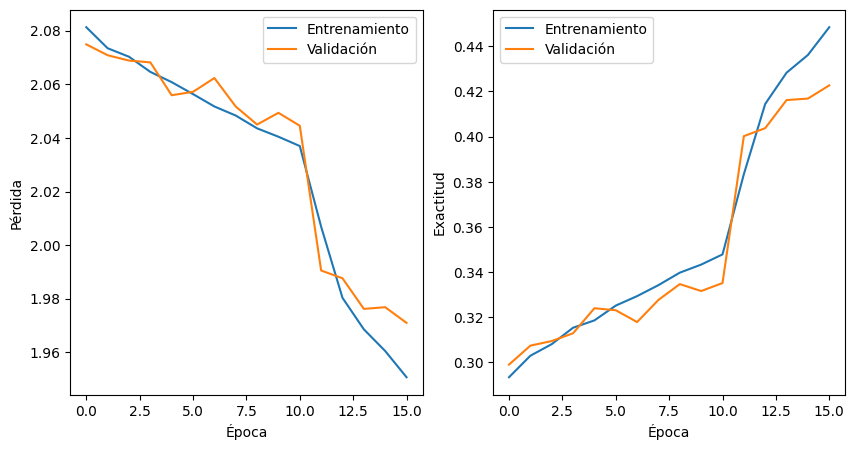

In [29]:
#ecm = nn.MSELoss()
model = DeepConv()
disp = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(disp)
ecm = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(model.parameters(),lr=0.0001)

#opt = SGD(model.parameters(), lr = 1e-3)

LOGDIR = './logs/'

model, mejor_conv, hist = entrena(model,
                                   ecm,
                                   exactitud,
                                   opt,
                                   trn_dl,
                                   val_dl,
                                   disp,
                                   LOGDIR + '/conv.pt',
                                   n_epocas=16,
                                   tbdir = LOGDIR)

f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

In [58]:
dir_raiz = 'FairFace'

test_ds = Face_age(X_test,y_test, dir_raiz, transform=tsfm)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, drop_last=True)

it_ent = iter(test_ds)
e=0.0
n=0
with torch.no_grad():
  for Xlote,ylote in test_dl:
    Xlote = Xlote.to(disp)
    ylote = ylote.to(disp)

    y_hat = mejor_conv(Xlote)
    e+=exactitud(y_hat, ylote).cpu()
    n+=1
e=e/n
print(f"Exactitud del conjunto de prueba {e}%")

Exactitud del conjunto de prueba 0.3016543984413147%


In [48]:
IMG_SIZE = 64

tsfm = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [49]:
convnext=tv.models.convnext_small()
convnext=tv.models.convnext_small(weights=tv.models.ConvNeXt_Small_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:13<00:00, 14.4MB/s]


In [50]:
for p in convnext.parameters():
    p.requires_grad = False

In [51]:
convnext.classifier[2]=nn.Linear(768,9)

In [52]:
def entrena_transferencia(modelo,
                          fp,
                          metrica,
                          opt,
                          entdl,
                          valdl,
                          disp,
                          ckptpath,
                          n_epocas = 10,
                          tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {
    'ent': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      },
    'val': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      }
  }

  tbwriter_ent = SummaryWriter(tbdir + '/ent')
  tbwriter_val = SummaryWriter(tbdir + '/val')

  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    for p, (Xlote,ylote) in enumerate(entdl):
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist["ent"]['perdida'][e] += perdida_paso
      hist["ent"][metrica.__name__][e] += metrica_paso

    # bucle de validación
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['val']['perdida'][e] += fp(y_hat, ylote)
        hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent'][metrica.__name__][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val'][metrica.__name__][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['val']['perdida'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter_ent, e, hist['ent'])
    registra_info_tboard(tbwriter_val, e, hist['val'])

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
          f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

  return modelo, mejor_modelo, hist

In [53]:
DC = 'cuda' if torch.cuda.is_available() else 'cpu'
convnext.to(DC)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(convnext.parameters(),
           lr=0.0006)

LOGDIR = './logs/'
convnext.eval()
convnext, mejor_convnext, hist = entrena_transferencia(convnext,
                                                       perdida,
                                                       exactitud,
                                                       opt,
                                                       trn_dl,
                                                       val_dl,
                                                       DC,
                                                       LOGDIR + '/convnext_tl.pt',
                                                       n_epocas=20,
                                                       tbdir = LOGDIR)


Época 0: Perdida(E) = 1.562, exactitud(E) = 0.385, Perdida(V) = 1.492, exactitud(V) = 0.410

Época 1: Perdida(E) = 1.473, exactitud(E) = 0.411, Perdida(V) = 1.472, exactitud(V) = 0.407

Época 2: Perdida(E) = 1.453, exactitud(E) = 0.419, Perdida(V) = 1.456, exactitud(V) = 0.419

Época 3: Perdida(E) = 1.439, exactitud(E) = 0.428, Perdida(V) = 1.448, exactitud(V) = 0.422

Época 4: Perdida(E) = 1.429, exactitud(E) = 0.429, Perdida(V) = 1.442, exactitud(V) = 0.419

Época 5: Perdida(E) = 1.421, exactitud(E) = 0.431, Perdida(V) = 1.441, exactitud(V) = 0.426

Época 6: Perdida(E) = 1.419, exactitud(E) = 0.432, Perdida(V) = 1.439, exactitud(V) = 0.421

Época 7: Perdida(E) = 1.411, exactitud(E) = 0.434, Perdida(V) = 1.438, exactitud(V) = 0.423

Época 8: Perdida(E) = 1.409, exactitud(E) = 0.432, Perdida(V) = 1.439, exactitud(V) = 0.420

Época 9: Perdida(E) = 1.404, exactitud(E) = 0.436, Perdida(V) = 1.438, exactitud(V) = 0.423

Época 10: Perdida(E) = 1.403, exactitud(E) = 0.438, Perdida(V) = 1.43

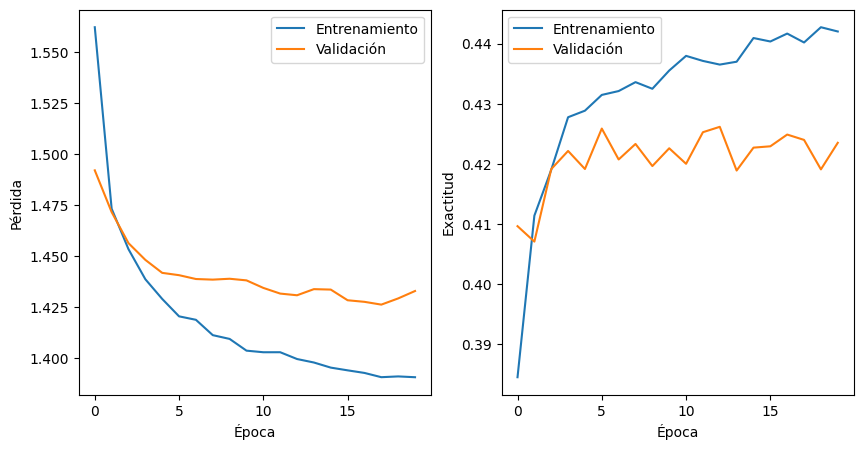

In [54]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

In [61]:
dir_raiz = 'FairFace'

test_ds = Face_age(X_test,y_test, dir_raiz, transform=tsfm)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, drop_last=True)

it_ent = iter(test_ds)
e=0.0
n=0
with torch.no_grad():
  for Xlote,ylote in test_dl:
    Xlote = Xlote.to(disp)
    ylote = ylote.to(disp)

    y_hat = mejor_convnext(Xlote)
    e+=exactitud(y_hat, ylote).cpu()
    n+=1
e=e/n
print(f"Exactitud del conjunto de prueba {e}%")

Exactitud del conjunto de prueba 0.4266543984413147%


In [ ]:
def entrena_ajuste_fino(modelo,
                        fp,
                        metrica,
                        opt,
                        entdl,
                        valdl,
                        disp,
                        ckptpath,
                        n_epocas = 10,
                        tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {
    'ent': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      },
    'val': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      }
  }

  tbwriter_ent = SummaryWriter(tbdir + '/ent')
  tbwriter_val = SummaryWriter(tbdir + '/val')

  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote,ylote) in enumerate(entdl):
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist["ent"]['perdida'][e] += perdida_paso
      hist["ent"][metrica.__name__][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['val']['perdida'][e] += fp(y_hat, ylote)
        hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent'][metrica.__name__][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val'][metrica.__name__][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['val']['perdida'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter_ent, e, hist['ent'])
    registra_info_tboard(tbwriter_val, e, hist['val'])

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
          f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

  return modelo, mejor_modelo, hist

In [ ]:
IMG_SIZE = 64

tsfm = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [ ]:
DC = 'cuda' if torch.cuda.is_available() else 'cpu'
convnext2=tv.models.convnext_small()
convnext2=tv.models.convnext_small(weights=tv.models.ConvNeXt_Small_Weights.IMAGENET1K_V1)

convnext2.classifier[2]=nn.Linear(768,9)

LOGDIR = './logs/'

convnext2.to(DC)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(convnext2.parameters(),
           lr=0.00003)

convnext2, mejor_convnext2, hist = entrena_ajuste_fino(convnext2,
                                                     perdida,
                                                     exactitud,
                                                     opt,
                                                     trn_dl,
                                                     val_dl,
                                                     DC,
                                                     LOGDIR + '/convnext_ft.pt',
                                                     n_epocas=10,
                                                     tbdir = LOGDIR)